In [6]:
import numpy as np, tensorflow as tf, tqdm
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
print(tf.__version__)
%matplotlib inline
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

1.5.0
Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [7]:
w1_initial = np.random.normal(size=(784,100)).astype(np.float32)
w2_initial = np.random.normal(size=(100,100)).astype(np.float32)
w3_initial = np.random.normal(size=(100,10)).astype(np.float32)

# 为BN层准备一个非常小的数字，防止出现分母为0的极端情况。
epsilon = 1e-3

## 从头开始实现Batch Normalization，验证其对网络训练的效果
构建两个计算图，均为3层网络（不算输入层的话）。其中：
一个是无BN的普通三层网络
一个是diy创建BN的隐藏层Layer 1，基于tensorflow创建BN的隐藏层Layer 2，输出层Layer 3

Layer 1 层：无BN

In [41]:
# Placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
# Layer 1 without BN
w1 = tf.Variable(w1_initial)
b1 = tf.Variable(tf.zeros([100]))
z1 = tf.matmul(x,w1)+b1
l1 = tf.nn.sigmoid(z1)

Layer 1 层：自定义BN

In [42]:
w1_BN = tf.Variable(w1_initial)

# 因为BN的引入，b的作用被BN层替代，可省略。
z1_BN = tf.matmul(x,w1_BN)

# 计算加权和的均值和方差，0是指batch这个维度
batch_mean1, batch_var1 = tf.nn.moments(z1_BN,[0])

# 正则化
z1_hat = (z1_BN - batch_mean1) / tf.sqrt(batch_var1 + epsilon)

# 新建两个变量scale and beta
scale1 = tf.Variable(tf.ones([100]))
beta1 = tf.Variable(tf.zeros([100]))

# 计算被还原的BN1，即BN文章里的y
BN1 = scale1 * z1_hat + beta1

# l1_BN = tf.nn.sigmoid(BN1)
l1_BN = tf.nn.relu(BN1)

Layer 2 层：无BN

In [43]:
w2 = tf.Variable(w2_initial)
b2 = tf.Variable(tf.zeros([100]))
z2 = tf.matmul(l1,w2)+b2
# l2 = tf.nn.sigmoid(z2)
l2 = tf.nn.relu(z2)

Layer 2 层：使用tensorflow创建BN

In [44]:
w2_BN = tf.Variable(w2_initial)
z2_BN = tf.matmul(l1_BN,w2_BN)

batch_mean2, batch_var2 = tf.nn.moments(z2_BN,[0])
scale2 = tf.Variable(tf.ones([100]))
beta2 = tf.Variable(tf.zeros([100]))
BN2 = tf.nn.batch_normalization(z2_BN,batch_mean2,batch_var2,beta2,scale2,epsilon)
# l2_BN = tf.nn.sigmoid(BN2)
l2_BN = tf.nn.relu(BN2)

Layer 3 层：接无BN的layer2

In [45]:
w3 = tf.Variable(w3_initial)
b3 = tf.Variable(tf.zeros([10]))
y  = tf.nn.softmax(tf.matmul(l2,w3)+b3)

Layer 3 层：接有BN的layer2

In [46]:
# w3_BN = tf.Variable(w3_initial)
# b3_BN = tf.Variable(tf.zeros([10]))
# y_BN  = tf.nn.softmax(tf.matmul(l2_BN,w3_BN)+b3_BN)

w3_BN = tf.Variable(w3_initial)
z3_BN = tf.matmul(l2_BN,w3_BN)

batch_mean3, batch_var3 = tf.nn.moments(z3_BN,[0])
scale3 = tf.Variable(tf.ones([10]))
beta3 = tf.Variable(tf.zeros([10]))
BN3 = tf.nn.batch_normalization(z3_BN,batch_mean3,batch_var3,beta3,scale3,epsilon)

print(BN3.get_shape())
y_BN  = tf.nn.softmax(BN3)

(?, 10)


定义损失、优化器、预测三个op，分别针对双层BN网络、单层BN网络。
损失使用交叉熵，因为我们输出层的激活函数为softmax。
优化器用梯度下降，因为我们是分批喂数，因此实际上就是分批SGD

In [47]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
cross_entropy_BN = -tf.reduce_sum(y_*tf.log(y_BN))

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
train_step_BN = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy_BN)

correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
correct_prediction_BN = tf.equal(tf.arg_max(y_BN,1),tf.arg_max(y_,1))
accuracy_BN = tf.reduce_mean(tf.cast(correct_prediction_BN,tf.float32))

训练

In [48]:
zs, BNs, acc, acc_BN = [], [], [], []

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in tqdm.tqdm(range(40000)):
    batch = mnist.train.next_batch(60)
    
    # 运行train_step，训练无BN网络
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    # 运行train_step_BN，训练有BN的网络
    train_step_BN.run(feed_dict={x: batch[0], y_: batch[1]})
    
    if i % 50 is 0:
        # 每50个batch，测一测精度，并把第二层的加权输入，没进BN层之前的z2，被BN层处理过的BN2，都算一遍
        res = sess.run([accuracy,accuracy_BN,z2,BN2],feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        
        # 保存训练阶段的精度记录，acc是无BN网络的记录，acc_BN是有BN网络的记录，
        acc.append(res[0])
        acc_BN.append(res[1])
        
        # 保存训练阶段的z2，BN2的历史记录
        zs.append(np.mean(res[2],axis=0)) # record the mean value of z2 over the entire test set
        BNs.append(np.mean(res[3],axis=0)) # record the mean value of BN2 over the entire test set

zs, BNs, acc, acc_BN = np.array(zs), np.array(BNs), np.array(acc), np.array(acc_BN)

100%|███████████████████████████████████| 40000/40000 [06:23<00:00, 104.32it/s]


绘制精度训练曲线，结果表明：BN的加入，大大提升了

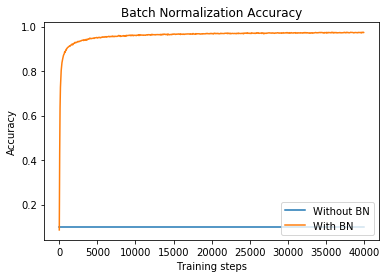

In [50]:
fig, ax = plt.subplots()

ax.plot(range(0,len(acc)*50,50),acc, label='Without BN')
ax.plot(range(0,len(acc)*50,50),acc_BN, label='With BN')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
# ax.set_ylim([0.8,1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

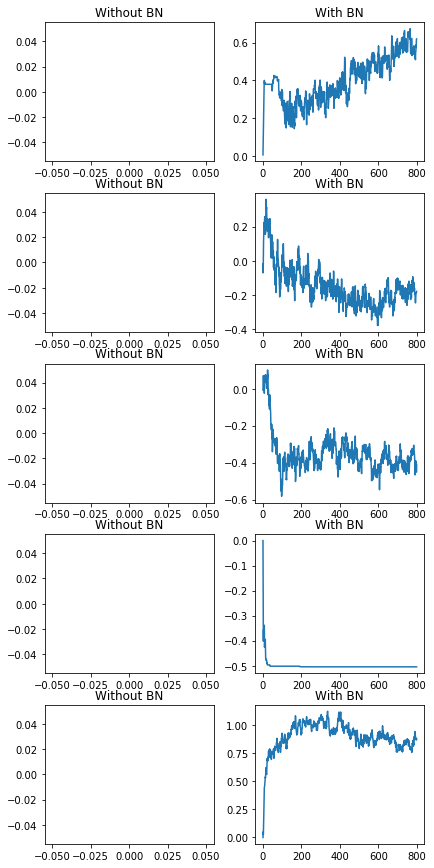

In [51]:
fig, axes = plt.subplots(5, 2, figsize=(6,12))
fig.tight_layout()

for i, ax in enumerate(axes):
    ax[0].set_title("Without BN")
    ax[1].set_title("With BN")
    ax[0].plot(zs[:,i])
    ax[1].plot(BNs[:,i])
plt.show()

In [52]:
predictions = []
correct = 0
for i in range(100):
    pred, corr = sess.run([tf.arg_max(y_BN,1), accuracy_BN],
                         feed_dict={x: [mnist.test.images[i]], y_: [mnist.test.labels[i]]})
    correct += corr
    predictions.append(pred[0])
print("PREDICTIONS:", predictions)
print("ACCURACY:", correct/100)
sess.close()

PREDICTIONS: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
ACCURACY: 0.02


## 实际应用的细节

需要注意一下几点：



In [58]:
# batch_norm_wrapper 是对tensorflow中BN层实现的一个核心功能的重现。
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py#L102
# 其功能是：对于每个batch的每一层的加权输入
# 在训练阶段，统计方差和均值，一边记录和更新总体方差和均值。
# 在测试/评估阶段，直接使用训练时统计好的总体方差和均值。
def batch_norm_wrapper(inputs, is_training, decay = 0.999):

    # 每个BN层，引入了4个变量 scale beta pop_mean pop_var，其中:
    # scale beta 是可训练的，训练结束后被保存为模型参数
    # pop_mean pop_var 是不可训练，只在训练中进行统计，
    # pop_mean pop_var 最终保存为模型的变量。在测试时重构的计算图会接入该变量，只要载入训练参数即可。
    scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
    beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

    if is_training:
        # 以下为训练时的BN计算图构造
        # batch_mean、batch_var在一个batch里的每一层，在前向传播时会计算一次，
        # 在反传时通过它来计算本层输入加权和的梯度，仅仅作为整个网络传递梯度的功能。在训练结束后被废弃。
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        
        # 通过移动指数平均的方式，把每一个batch的统计量汇总进来，更新总体统计量的估计值pop_mean、pop_var
        # assign构建计算图一个operation，即把pop_mean * decay + batch_mean * (1 - decay) 赋值给pop_mean
        train_mean = tf.assign(pop_mean,pop_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(pop_var,pop_var * decay + batch_var * (1 - decay))

        # 确保本层的train_mean、train_var这两个operation都执行了，才进行BN。
        with tf.control_dependencies([train_mean, train_var]):
            return tf.nn.batch_normalization(inputs,batch_mean, batch_var, beta, scale, epsilon)
    else:
        # 以下为测试时的BN计算图构造，即直接载入已训练模型的beta, scale,已训练模型中保存的pop_mean, pop_var
        return tf.nn.batch_normalization(inputs,pop_mean, pop_var, beta, scale, epsilon)

构造计算图，其中通过调用上面定义好的BN包装器，实现BN层的简洁添加。

In [59]:
def build_graph(is_training):
    x = tf.placeholder(tf.float32, shape=[None, 784],name="x")
    y_ = tf.placeholder(tf.float32, shape=[None, 10],name="y_")

    w1 = tf.Variable(w1_initial)
    z1 = tf.matmul(x,w1)
    bn1 = batch_norm_wrapper(z1, is_training)
    l1 = tf.nn.sigmoid(bn1)

    w2 = tf.Variable(w2_initial)
    z2 = tf.matmul(l1,w2)
    bn2 = batch_norm_wrapper(z2, is_training)
    l2 = tf.nn.sigmoid(bn2)

    w3 = tf.Variable(w3_initial)
    # b3 = tf.Variable(tf.zeros([10]))
    # y  = tf.nn.softmax(tf.matmul(l2, w3))
    z3 = tf.matmul(l2,w3)
    bn3 = batch_norm_wrapper(z3, is_training)
    y  = tf.nn.softmax(bn3)


    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32),name='accuracy')

    return (x, y_), train_step, accuracy, y

In [78]:
def build_graph_0(is_training):
    x = tf.placeholder(tf.float32, shape=[None, 784],name="x")
    y_ = tf.placeholder(tf.float32, shape=[None, 10],name="y_")

    w1 = tf.Variable(w1_initial)
    b1 = tf.Variable(tf.zeros([100]))
    l1 = tf.nn.sigmoid(tf.matmul(x, w1)+b1)

    w2 = tf.Variable(w2_initial)
    b2 = tf.Variable(tf.zeros([100]))
    l2 = tf.nn.sigmoid(tf.matmul(l1, w2)+b2)

    w3 = tf.Variable(w3_initial)
    b3 = tf.Variable(tf.zeros([10]))
    y  = tf.nn.softmax(tf.matmul(l2, w3)+b3)

    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32),name='accuracy')

    return (x, y_), train_step, accuracy, y

def build_graph_1(is_training):
    x = tf.placeholder(tf.float32, shape=[None, 784],name="x")
    y_ = tf.placeholder(tf.float32, shape=[None, 10],name="y_")

    w1 = tf.Variable(w1_initial)
    z1 = tf.matmul(x,w1)
    bn1 = batch_norm_wrapper(z1, is_training)
    l1 = tf.nn.sigmoid(bn1)

    w2 = tf.Variable(w2_initial)
    b2 = tf.Variable(tf.zeros([100]))
    l2 = tf.nn.sigmoid(tf.matmul(l1, w2)+b2)

    w3 = tf.Variable(w3_initial)
    b3 = tf.Variable(tf.zeros([10]))
    y  = tf.nn.softmax(tf.matmul(l2, w3)+b3)

    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32),name='accuracy')

    return (x, y_), train_step, accuracy, y

def build_graph_2(is_training):
    x = tf.placeholder(tf.float32, shape=[None, 784],name="x")
    y_ = tf.placeholder(tf.float32, shape=[None, 10],name="y_")

    w1 = tf.Variable(w1_initial)
    z1 = tf.matmul(x,w1)
    bn1 = batch_norm_wrapper(z1, is_training)
    l1 = tf.nn.sigmoid(bn1)

    w2 = tf.Variable(w2_initial)
    z2 = tf.matmul(l1,w2)
    bn2 = batch_norm_wrapper(z2, is_training)
    l2 = tf.nn.sigmoid(bn2)

    w3 = tf.Variable(w3_initial)
    b3 = tf.Variable(tf.zeros([10]))
    y  = tf.nn.softmax(tf.matmul(l2, w3)+b3)

    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32),name='accuracy')

    return (x, y_), train_step, accuracy, y

def build_graph_3(is_training):
    x = tf.placeholder(tf.float32, shape=[None, 784],name="x")
    y_ = tf.placeholder(tf.float32, shape=[None, 10],name="y_")

    w1 = tf.Variable(w1_initial)
    z1 = tf.matmul(x,w1)
    bn1 = batch_norm_wrapper(z1, is_training)
    l1 = tf.nn.sigmoid(bn1)

    w2 = tf.Variable(w2_initial)
    z2 = tf.matmul(l1,w2)
    bn2 = batch_norm_wrapper(z2, is_training)
    l2 = tf.nn.sigmoid(bn2)

    w3 = tf.Variable(w3_initial)
    # b3 = tf.Variable(tf.zeros([10]))
    # y  = tf.nn.softmax(tf.matmul(l2, w3))
    z3 = tf.matmul(l2,w3)
    bn3 = batch_norm_wrapper(z3, is_training)
    y  = tf.nn.softmax(bn3)


    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32),name='accuracy')

    return (x, y_), train_step, accuracy, y

训练

In [61]:
#Build training graph, train and save the trained model


tf.reset_default_graph()
# (x, y_), train_step, accuracy, _, saver = build_graph(is_training=True)

(x, y_), train_step, accuracy, _,= build_graph(is_training=True)


acc = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm.tqdm(range(10000)):
        batch = mnist.train.next_batch(60)
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})
        if i % 200 is 0:
            res = sess.run([accuracy],feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            acc.append(res[0])
            # print('batch:',i,'    accuracy:',res[0])
    # 保存模型，注意该模型是不可用的。因为其计算图是训练的计算图。
    saver=tf.train.Saver()
    # saved_model = saver.save(sess, './temp-bn-save')
    saver.save(sess, './bn_test/temp-bn-save')

print("Final accuracy:", acc[-1])
sess.close()

  0%|                                                | 0/10000 [00:00<?, ?it/s]

batch: 0     accuracy: 0.1011


  2%|▋                                     | 189/10000 [00:02<02:30, 65.15it/s]

batch: 200     accuracy: 0.7937


  4%|█▍                                   | 386/10000 [00:03<00:53, 178.67it/s]

batch: 400     accuracy: 0.858


  6%|██▏                                  | 594/10000 [00:04<00:41, 225.50it/s]

batch: 600     accuracy: 0.8776


  8%|██▉                                  | 781/10000 [00:05<00:41, 221.87it/s]

batch: 800     accuracy: 0.8902


 10%|███▌                                 | 975/10000 [00:06<00:32, 278.10it/s]

batch: 1000     accuracy: 0.8968


 12%|████▎                               | 1186/10000 [00:07<00:35, 247.65it/s]

batch: 1200     accuracy: 0.9023


 14%|████▉                               | 1378/10000 [00:08<00:31, 277.18it/s]

batch: 1400     accuracy: 0.9079


 16%|█████▋                              | 1567/10000 [00:08<00:29, 287.66it/s]

batch: 1600     accuracy: 0.911


 18%|██████▍                             | 1798/10000 [00:09<00:25, 322.26it/s]

batch: 1800     accuracy: 0.914


 20%|███████                             | 1970/10000 [00:10<00:26, 307.88it/s]

batch: 2000     accuracy: 0.9158


 22%|███████▉                            | 2197/10000 [00:11<00:28, 277.21it/s]

batch: 2200     accuracy: 0.9184


 24%|████████▌                           | 2395/10000 [00:12<00:24, 304.39it/s]

batch: 2400     accuracy: 0.9183


 26%|█████████▎                          | 2582/10000 [00:12<00:28, 264.38it/s]

batch: 2600     accuracy: 0.9195


 28%|██████████                          | 2781/10000 [00:13<00:24, 295.19it/s]

batch: 2800     accuracy: 0.9236


 30%|██████████▋                         | 2966/10000 [00:14<00:29, 240.21it/s]

batch: 3000     accuracy: 0.9238


 32%|███████████▍                        | 3170/10000 [00:15<00:25, 271.05it/s]

batch: 3200     accuracy: 0.9256


 34%|████████████▏                       | 3385/10000 [00:16<00:23, 285.05it/s]

batch: 3400     accuracy: 0.9259


 36%|████████████▉                       | 3592/10000 [00:16<00:20, 310.02it/s]

batch: 3600     accuracy: 0.9296


 38%|█████████████▋                      | 3793/10000 [00:17<00:20, 304.59it/s]

batch: 3800     accuracy: 0.9314


 40%|██████████████▎                     | 3984/10000 [00:18<00:24, 247.20it/s]

batch: 4000     accuracy: 0.9305


 42%|███████████████                     | 4173/10000 [00:19<00:23, 249.08it/s]

batch: 4200     accuracy: 0.9312


 44%|███████████████▊                    | 4396/10000 [00:20<00:19, 293.92it/s]

batch: 4400     accuracy: 0.9364


 46%|████████████████▌                   | 4595/10000 [00:21<00:19, 280.67it/s]

batch: 4600     accuracy: 0.9345


 48%|█████████████████▎                  | 4796/10000 [00:21<00:19, 261.10it/s]

batch: 4800     accuracy: 0.9373


 50%|█████████████████▉                  | 4988/10000 [00:22<00:17, 284.73it/s]

batch: 5000     accuracy: 0.9367


 52%|██████████████████▌                 | 5171/10000 [00:23<00:23, 203.79it/s]

batch: 5200     accuracy: 0.9398


 54%|███████████████████▎                | 5368/10000 [00:24<00:15, 296.93it/s]

batch: 5400     accuracy: 0.94


 56%|████████████████████                | 5565/10000 [00:25<00:14, 308.67it/s]

batch: 5600     accuracy: 0.9412


 58%|████████████████████▊               | 5798/10000 [00:25<00:14, 280.48it/s]

batch: 5800     accuracy: 0.9401


 60%|█████████████████████▌              | 5991/10000 [00:26<00:13, 299.21it/s]

batch: 6000     accuracy: 0.945


 62%|██████████████████████▎             | 6195/10000 [00:27<00:18, 211.36it/s]

batch: 6200     accuracy: 0.9447


 64%|██████████████████████▉             | 6380/10000 [00:28<00:18, 194.49it/s]

batch: 6400     accuracy: 0.9447


 66%|███████████████████████▊            | 6598/10000 [00:29<00:16, 208.42it/s]

batch: 6600     accuracy: 0.9463


 68%|████████████████████████▍           | 6780/10000 [00:30<00:11, 284.69it/s]

batch: 6800     accuracy: 0.9472


 70%|█████████████████████████           | 6977/10000 [00:31<00:10, 294.05it/s]

batch: 7000     accuracy: 0.9464


 72%|█████████████████████████▊          | 7180/10000 [00:31<00:09, 294.66it/s]

batch: 7200     accuracy: 0.9484


 74%|██████████████████████████▌         | 7386/10000 [00:32<00:08, 321.63it/s]

batch: 7400     accuracy: 0.9487


 76%|███████████████████████████▎        | 7570/10000 [00:33<00:09, 254.87it/s]

batch: 7600     accuracy: 0.9495


 78%|████████████████████████████        | 7788/10000 [00:34<00:10, 215.15it/s]

batch: 7800     accuracy: 0.9506


 80%|████████████████████████████▊       | 7998/10000 [00:35<00:07, 280.75it/s]

batch: 8000     accuracy: 0.9515


 82%|█████████████████████████████▍      | 8181/10000 [00:35<00:06, 278.42it/s]

batch: 8200     accuracy: 0.9522


 84%|██████████████████████████████▏     | 8382/10000 [00:36<00:05, 293.44it/s]

batch: 8400     accuracy: 0.9515


 86%|██████████████████████████████▉     | 8581/10000 [00:37<00:04, 296.45it/s]

batch: 8600     accuracy: 0.9543


 88%|███████████████████████████████▋    | 8796/10000 [00:38<00:04, 241.04it/s]

batch: 8800     accuracy: 0.9548


 90%|████████████████████████████████▍   | 8996/10000 [00:39<00:03, 263.86it/s]

batch: 9000     accuracy: 0.953


 92%|█████████████████████████████████   | 9173/10000 [00:40<00:03, 250.43it/s]

batch: 9200     accuracy: 0.9565


 94%|█████████████████████████████████▊  | 9400/10000 [00:40<00:02, 260.35it/s]

batch: 9400     accuracy: 0.955


 96%|██████████████████████████████████▌ | 9591/10000 [00:41<00:01, 289.83it/s]

batch: 9600     accuracy: 0.9561


 98%|███████████████████████████████████▏| 9778/10000 [00:42<00:00, 240.97it/s]

batch: 9800     accuracy: 0.9566


100%|███████████████████████████████████| 10000/10000 [00:43<00:00, 230.59it/s]


Final accuracy: 0.9566


In [79]:
#Build training graph, train and save the trained model


tf.reset_default_graph()
(x, y_), train_step, accuracy, _,= build_graph_0(is_training=True)


acc0 = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm.tqdm(range(10000)):
        batch = mnist.train.next_batch(60)
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})
        if i % 200 is 0:
            res = sess.run([accuracy],feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            acc0.append(res[0])
            # print('batch:',i,'    accuracy:',res[0])
    # 保存模型，注意该模型是不可用的。因为其计算图是训练的计算图。
    # saver=tf.train.Saver()
    # saved_model = saver.save(sess, './temp-bn-save')
    # saver.save(sess, './bn_test/temp-bn-save')

print("0 Final accuracy:", acc0[-1])
sess.close()


tf.reset_default_graph()
(x, y_), train_step, accuracy, _,= build_graph_1(is_training=True)
acc1 = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm.tqdm(range(10000)):
        batch = mnist.train.next_batch(60)
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})
        if i % 200 is 0:
            res = sess.run([accuracy],feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            acc1.append(res[0])
            # print('batch:',i,'    accuracy:',res[0])
    # 保存模型，注意该模型是不可用的。因为其计算图是训练的计算图。
    # saver=tf.train.Saver()
    # saved_model = saver.save(sess, './temp-bn-save')
    # saver.save(sess, './bn_test/temp-bn-save')

print("1 Final accuracy:", acc1[-1])
sess.close()


tf.reset_default_graph()
(x, y_), train_step, accuracy, _,= build_graph_2(is_training=True)
acc2 = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm.tqdm(range(10000)):
        batch = mnist.train.next_batch(60)
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})
        if i % 200 is 0:
            res = sess.run([accuracy],feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            acc2.append(res[0])
            # print('batch:',i,'    accuracy:',res[0])
    # 保存模型，注意该模型是不可用的。因为其计算图是训练的计算图。
    # saver=tf.train.Saver()
    # saved_model = saver.save(sess, './temp-bn-save')
    # saver.save(sess, './bn_test/temp-bn-save')

print("2 Final accuracy:", acc2[-1])
sess.close()

tf.reset_default_graph()
(x, y_), train_step, accuracy, _,= build_graph_3(is_training=True)
acc3 = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm.tqdm(range(10000)):
        batch = mnist.train.next_batch(60)
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})
        if i % 200 is 0:
            res = sess.run([accuracy],feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            acc3.append(res[0])
            # print('batch:',i,'    accuracy:',res[0])
    # 保存模型，注意该模型是不可用的。因为其计算图是训练的计算图。
    # saver=tf.train.Saver()
    # saved_model = saver.save(sess, './temp-bn-save')
    # saver.save(sess, './bn_test/temp-bn-save')

print("3 Final accuracy:", acc3[-1])
sess.close()

100%|███████████████████████████████████| 10000/10000 [00:27<00:00, 357.53it/s]


0 Final accuracy: 0.098


100%|███████████████████████████████████| 10000/10000 [00:31<00:00, 322.18it/s]


1 Final accuracy: 0.098


100%|███████████████████████████████████| 10000/10000 [00:35<00:00, 280.25it/s]


2 Final accuracy: 0.9702


100%|███████████████████████████████████| 10000/10000 [00:38<00:00, 257.44it/s]


3 Final accuracy: 0.9717


绘制一个三层网络的训练曲线，
结构分别是无BN、仅第一层加BN，仅前两层加BN、三层都加BN。
验证结果：BN层越多，对covariate shift问题解决得越好，训练曲线也就越好。

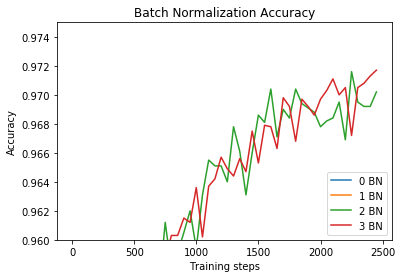

In [87]:
fig, ax = plt.subplots()
ax.plot(range(0,len(acc0)*50,50),acc0, label='0 BN')
ax.plot(range(0,len(acc1)*50,50),acc1, label='1 BN')
ax.plot(range(0,len(acc2)*50,50),acc2, label='2 BN')
ax.plot(range(0,len(acc3)*50,50),acc3, label='3 BN')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
# ax.set_ylim([0.8,1])
# ax.set_ylim([0.87,0.97])
ax.set_ylim([0.96,0.975])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

In [ ]:
sess.close()
tf.reset_default_graph()
# (x, y_), _, accuracy, y, saver = build_graph(is_training=False)
(x, y_), _, accuracy, y = build_graph(is_training=False)

predictions = []
correct = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # 读取训练时模型，将学到的权重参数、估计的总体均值、方差，通过restore，载入到运行的计算图中。
    saver=tf.train.Saver()
    saver.restore(sess, './bn_test/temp-bn-save')
    saver.save(sess, './bn_release/temp-bn-save')
    
    for i in range(100):
        pred, corr = sess.run([tf.arg_max(y,1), accuracy],
                             feed_dict={x: [mnist.test.images[i]], y_: [mnist.test.labels[i]]})
        correct += corr
        predictions.append(pred[0])
print("PREDICTIONS:", predictions)
print("ACCURACY:", correct/100)


In [ ]:
sess.close()
tf.reset_default_graph()
# (x, y_), _, accuracy, y, saver = build_graph(is_training=False)
# (x, y_), _, accuracy, y = build_graph(is_training=False)
graph = tf.get_default_graph()
predictions = []
correct = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.import_meta_graph('./bn_release/temp-bn-save.meta')
    saver.restore(sess,'./bn_release/temp-bn-save')
    all_tensor = tf.get_default_graph().as_graph_def().node
    print(all_tensor)
    
    #将要学习的新数据
    x = graph.get_tensor_by_name("x:0")
    y_ = graph.get_tensor_by_name("y_:0")
    accuracy = graph.get_tensor_by_name("accuracy:0")
    print(sess.run(accuracy,feed_dict={x: [mnist.test.images], y_: [mnist.test.labels]}))

In [ ]:
print(mnist.test.images.shape)
print(mnist.test.labels)